In [33]:
import pandas as pd 

In [34]:
data = pd.read_csv("../dataset_full_texts.csv")
data.head()

,doc_id,url,cache,fulltext,nature,published,entity_name,entity_type,geo_path,extracted_text
0,2713/e87b2_Plan_Action_CASGBS.pdf,https://www.saintgermainbouclesdeseine.fr/wp-c...,https://datapolitics-public.s3.gra.io.cloud.ov...,https://datapolitics-public.s3.gra.io.cloud.ov...,NaN,2023-01-01 00:00:00,CA Saint Germain Boucles de Seine (78),Intercommunalité,CA Saint Germain Boucles de Seine (78)/Yveline...,COMMUNAUTÉ D’AGGLOMERATION SAINT GERMAIN BOUCL...
1,2713/9eef1_Resume_Non_Techniques_CASGBS.pdf,https://www.saintgermainbouclesdeseine.fr/wp-c...,https://datapolitics-public.s3.gra.io.cloud.ov...,https://datapolitics-public.s3.gra.io.cloud.ov...,NaN,2023-01-01 00:00:00,CA Saint Germain Boucles de Seine (78),Intercommunalité,CA Saint Germain Boucles de Seine (78)/Yveline...,COMMUNAUTÉ D’AGGLOMÉRATION SAINT GERMAIN BOUCL...
2,2713/e3f75_Evaluation_Environnementale_Strateg...,https://www.saintgermainbouclesdeseine.fr/wp-c...,https://datapolitics-public.s3.gra.io.cloud.ov...,https://datapolitics-public.s3.gra.io.cloud.ov...,NaN,2023-01-01 00:00:00,CA Saint Germain Boucles de Seine (78),Intercommunalité,CA Saint Germain Boucles de Seine (78)/Yveline...,COMMUNAUTÉ D’AGGLOMÉRATION SAINT GERMAIN BOUCL...
3,2713/6ed88_Rapport-Strategique_CASGBS.pdf,https://www.saintgermainbouclesdeseine.fr/wp-c...,https://datapolitics-public.s3.gra.io.cloud.ov...,https://datapolitics-public.s3.gra.io.cloud.ov...,NaN,2023-01-01 00:00:00,CA Saint Germain Boucles de Seine (78),Intercommunalité,CA Saint Germain Boucles de Seine (78)/Yveline...,COMMUNAUTÉ D’AGGLOMÉRATION SAINT GERMAIN BOUCL...
4,1796/69a6d_chinon_actus_octobre_2022_stc.pdf,https://www.ville-chinon.com/fileadmin/contenu...,https://datapolitics-public.s3.gra.io.cloud.ov...,https://datapolitics-public.s3.gra.io.cloud.ov...,NaN,2023-01-01 00:00:00,Chinon,Commune,"Chinon/CC Chinon, Vienne et Loire/Indre-et-Loi...",chinon le mag MAgazine MUNICIPAL / octobre 202...


In [35]:
data.shape

(16172, 10)

In [62]:
data["nature"].value_counts()

nature
comm              3688
pv.cr             2755
dlao.plu          2573
acte.delib        1168
other              694
acte.arrete        518
pv.full            434
bdj                269
dlao.autres        174
acte.raa            35
mp.reglement         3
bdj.annexes          2
rapport              2
mp.annonce           1
comm.demarches       1
Name: count, dtype: int64

In [36]:
data_sample = data.sample(3000, random_state=42)

## Computing Text Embeddings

In [37]:
import torch
device = torch.device("cuda")

In [38]:
from sentence_transformers import SentenceTransformer

model =  SentenceTransformer("dangvantuan/sentence-camembert-base")

In [39]:
data_sample["embeddings"] = data_sample["extracted_text"].apply(lambda text: model.encode(text))

## Clustering

In [40]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

text_embeddings = data_sample["embeddings"].to_list()

kmeans = KMeans(n_clusters=2, random_state=40)
kmeans.fit(text_embeddings)

KMeans(n_clusters=2, random_state=40)

### Quantitaive Results

In [41]:
klabels = kmeans.labels_

sil_score = silhouette_score(text_embeddings, klabels, random_state=42)
cal_score = calinski_harabasz_score(text_embeddings, klabels) # between-clusters dispersion and of within-cluster dispersion

print(sil_score) # not too good
print(cal_score) # use it to compare clustering methods

0.05778549
217.54960435744619


In [42]:
data_sample["clustering_labels"] = klabels

In [43]:
data_sample["clustering_labels"].value_counts()

clustering_labels
0    1798
1    1202
Name: count, dtype: int64

### Qualitative Results

In [44]:
cluster_one = data_sample[data_sample["clustering_labels"] == 0]
cluster_two = data_sample[data_sample["clustering_labels"] == 1]

In [45]:
cluster_one_text  = cluster_one["extracted_text"].to_list()
cluster_two_text  = cluster_two["extracted_text"].to_list()

In [46]:
import spacy
nlp = spacy.load("fr_core_news_sm")

In [47]:
cluster_one_text_lemmas = []
for text in cluster_one_text:
    lemmas = [token.lemma_.lower() for token in nlp(text)]
    cluster_one_text_lemmas.append(lemmas)

In [48]:
cluster_two_text_lemmas = []
for text in cluster_two_text:
    lemmas = [token.lemma_.lower() for token in nlp(text)]
    cluster_two_text_lemmas.append(lemmas)

In [49]:
import itertools
cluster_one_text_lemmas = list(itertools.chain.from_iterable(cluster_one_text_lemmas))
cluster_two_text_lemmas = list(itertools.chain.from_iterable(cluster_two_text_lemmas))

In [58]:
from spacy.lang.fr import stop_words

stopwords = stop_words.STOP_WORDS
cluster_one_text_lemmas = [lemma for lemma in cluster_one_text_lemmas if lemma not in stopwords]
cluster_two_text_lemmas = [lemma for lemma in cluster_two_text_lemmas if lemma not in stopwords]

In [59]:
cluster_one_string = " ".join(cluster_one_text_lemmas)
cluster_two_string = " ".join(cluster_two_text_lemmas)

In [60]:
from wordcloud import WordCloud

wordcloud_cluster_one = WordCloud().generate(cluster_one_string)
wordcloud_cluster_two = WordCloud().generate(cluster_two_string)

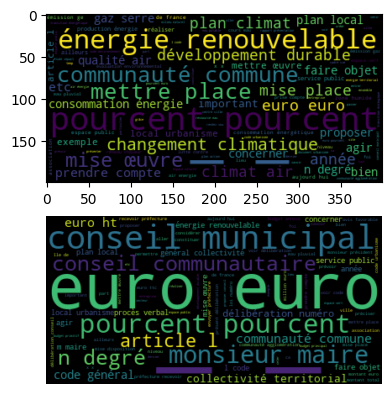

In [61]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1)

ax[0].imshow(wordcloud_cluster_one, interpolation='bilinear')
plt.axis("off")

ax[1].imshow(wordcloud_cluster_two, interpolation='bilinear')

plt.axis("off")
plt.show()